### This document contains the transition functions for each of the examples that we use. 


For each example we will write the following functions:
- F from noise. 
- G from noise.
- f weight function
- g weight function.

And the Optimal Sample and Weight function where applicable.

In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

## Constants

In [2]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.5

# AR(1) Example

In [3]:
SIGMA_Y = 12.8

def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val


def ar1_g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """    
    return total_noise * jnp.sqrt(TAU) * SIGMA_Y + all_particles


In [4]:

def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 


def ar1_g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, jnp.sqrt(TAU) * SIGMA_Y)



Optimal Functions

In [5]:
def ar1_optimal_sample(subkey, particles, Y_array, idt):

    mean_reversion_term = particles + TAU * KAPPA * (X_BAR - particles)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    new_particles = jax.random.normal(subkey, len(particles)) * jnp.sqrt(optimal_var) + optimal_mean
    
    return new_particles


def ar1_optimal_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    mean_reversion_term = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)
    optimal_var = (1 / (TAU * SIGMA_SIGMA**2) + 1 / (TAU * SIGMA_Y**2))**(-1)

    optimal_mean_numerator = (mean_reversion_term / (TAU * SIGMA_SIGMA**2)) + (Y_array.at[idt].get() / (TAU * SIGMA_Y**2)) 
    optimal_mean = optimal_mean_numerator * optimal_var
    
    proposal_term = jsp.stats.norm.logpdf(particle, optimal_mean, jnp.sqrt(optimal_var))

    f_term = jsp.stats.norm.logpdf(particle, mean_reversion_term, jnp.sqrt(TAU) * SIGMA_SIGMA)
    g_term = jsp.stats.norm.logpdf(Y_array.at[idt].get(), particle, jnp.sqrt(TAU) * SIGMA_Y)

    return f_term + g_term - proposal_term


# Stochastic Volatility Example

In [6]:
# f from noise is same as before.

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = -0.5 * TAU * jnp.exp(2 * all_particles)
    y_stds = jnp.sqrt(TAU) * jnp.exp(all_particles)
    
    return total_noise * y_stds + y_means

In [7]:
# f likelihood is same as before

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    std = jnp.sqrt(TAU) * jnp.exp(prev_particle)  # full variance
    mean = -0.5 * std**2  # expected mean
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


# Stochastic Volatility with Skew Example

In [8]:
# f from noise is same as before.

def skew_g_from_total_noise(prev_particle, particle, noise):
    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    return skew_total_mean + noise * jnp.sqrt(skew_total_var)

In [9]:
# f likelihood is same as before.

def skew_observation_weight_single(particle, prev_particle, Y_array, idt):

    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Skew-normal distribution parameters for Y[t]
    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO  * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    # Return log-likelihood: log P(Y[idt] | X_t, X_{t-1})
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), skew_total_mean, jnp.sqrt(skew_total_var))



# Testing Function as we go. 


### Data Generation.

We load up the PFVehicle for each of the examples, we then generate data from the examples. Plotting as we go, we should be able to notice the diffenrence

In [10]:
import matplotlib.pyplot as plt
from nnp_functions.pf_vehicle import PFVehicle

ar1_pf_vehicle = PFVehicle(f_from_noise, ar1_g_from_total_noise, f_likelihood_single, ar1_g_likelihood_single)
stoch_pf_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)
skew_pf_vehicle = PFVehicle(f_from_noise, skew_g_from_total_noise, f_likelihood_single, skew_observation_weight_single)


In [11]:
result = skew_pf_vehicle.generate_training_data(jax.random.PRNGKey(0), 100, 100, X_BAR)


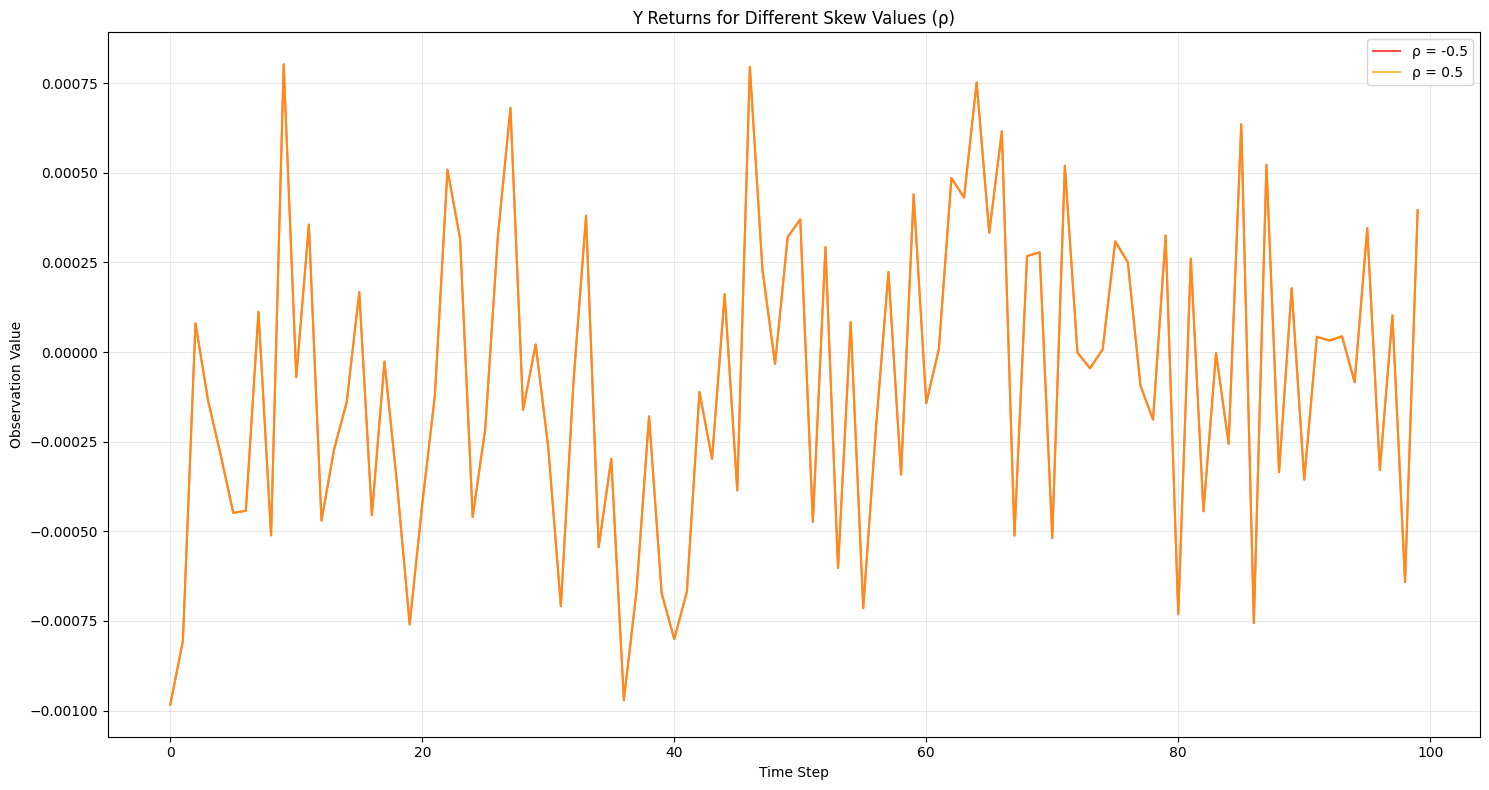

Summary statistics for different skew values:
--------------------------------------------------
ρ = -0.5: Mean =  -0.0001, Std =   0.0004, Min =  -0.0010, Max =   0.0008
ρ =  0.5: Mean =  -0.0001, Std =   0.0004, Min =  -0.0010, Max =   0.0008


In [12]:
## Plot y_returns for various skew values to see the effect

def get_noise(rho):
    def skew_g_from_total_noise(prev_particle, particle, noise):
        # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
        mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

        # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
        skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + rho * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)

        # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
        skew_total_var = TAU * jnp.exp(2 * particle) * (1 - rho**2)

        return skew_total_mean + noise * jnp.sqrt(skew_total_var)
    
    return skew_g_from_total_noise

# Test different skew values
skew_values = [-0.5, 0.5]
y_results = {}

for rho in skew_values:
    skew_pf_vehicle = PFVehicle(f_from_noise, get_noise(rho), f_likelihood_single, skew_observation_weight_single)
    x_data, y_data = skew_pf_vehicle.generate_data(jax.random.PRNGKey(0), 100, 100, X_BAR)
    y_results[rho] = y_data[0]  # Take first trajectory

# Plot results
plt.figure(figsize=(15, 8))
colors = ['red', 'orange', 'green', 'blue', 'purple']

for i, rho in enumerate(skew_values):
    plt.plot(y_results[rho], label=f'ρ = {rho}', color=colors[i], alpha=0.7)

plt.title('Y Returns for Different Skew Values (ρ)')
plt.xlabel('Time Step')
plt.ylabel('Observation Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Also show summary statistics
print("Summary statistics for different skew values:")
print("-" * 50)
for rho in skew_values:
    y_data = y_results[rho]
    print(f"ρ = {rho:4.1f}: Mean = {jnp.mean(y_data):8.4f}, Std = {jnp.std(y_data):8.4f}, Min = {jnp.min(y_data):8.4f}, Max = {jnp.max(y_data):8.4f}")


This has made you doubt the skew model a bit, the main notieable effect happens by dampning the mean I feel that this wont be that accurate in practice.

### Testing the particle Filters.

The particle filter should run without issue for all of the data distributions. 

Before you can test you need to create the bootstrap sample function from f_from_noise_fn

In [13]:
def sample_fn_from_f_from_noise(f_from_noise_fn):
    
    def sample_fn(subkey, particles, Y_array, idt):
        return f_from_noise_fn(particles, jax.random.normal(subkey, len(particles)))
    
    return sample_fn

# We are now ready to test the particle filters


--- Testing Particle Filter: Stochastic Volatility ---
Final ESS: 1918.86
Average MSE: 1.22004e-02

--- Testing Particle Filter: Stochastic Volatility with Skew ---
Final ESS: 1600.30
Average MSE: 3.25822e-02

--- Testing Particle Filter: AR(1) ---
Final ESS: 1494.06
Average MSE: 5.39246e-04

--- Testing Particle Filter: AR(1) Optimal ---
Final ESS: 1650.24
Average MSE: 5.38292e-04


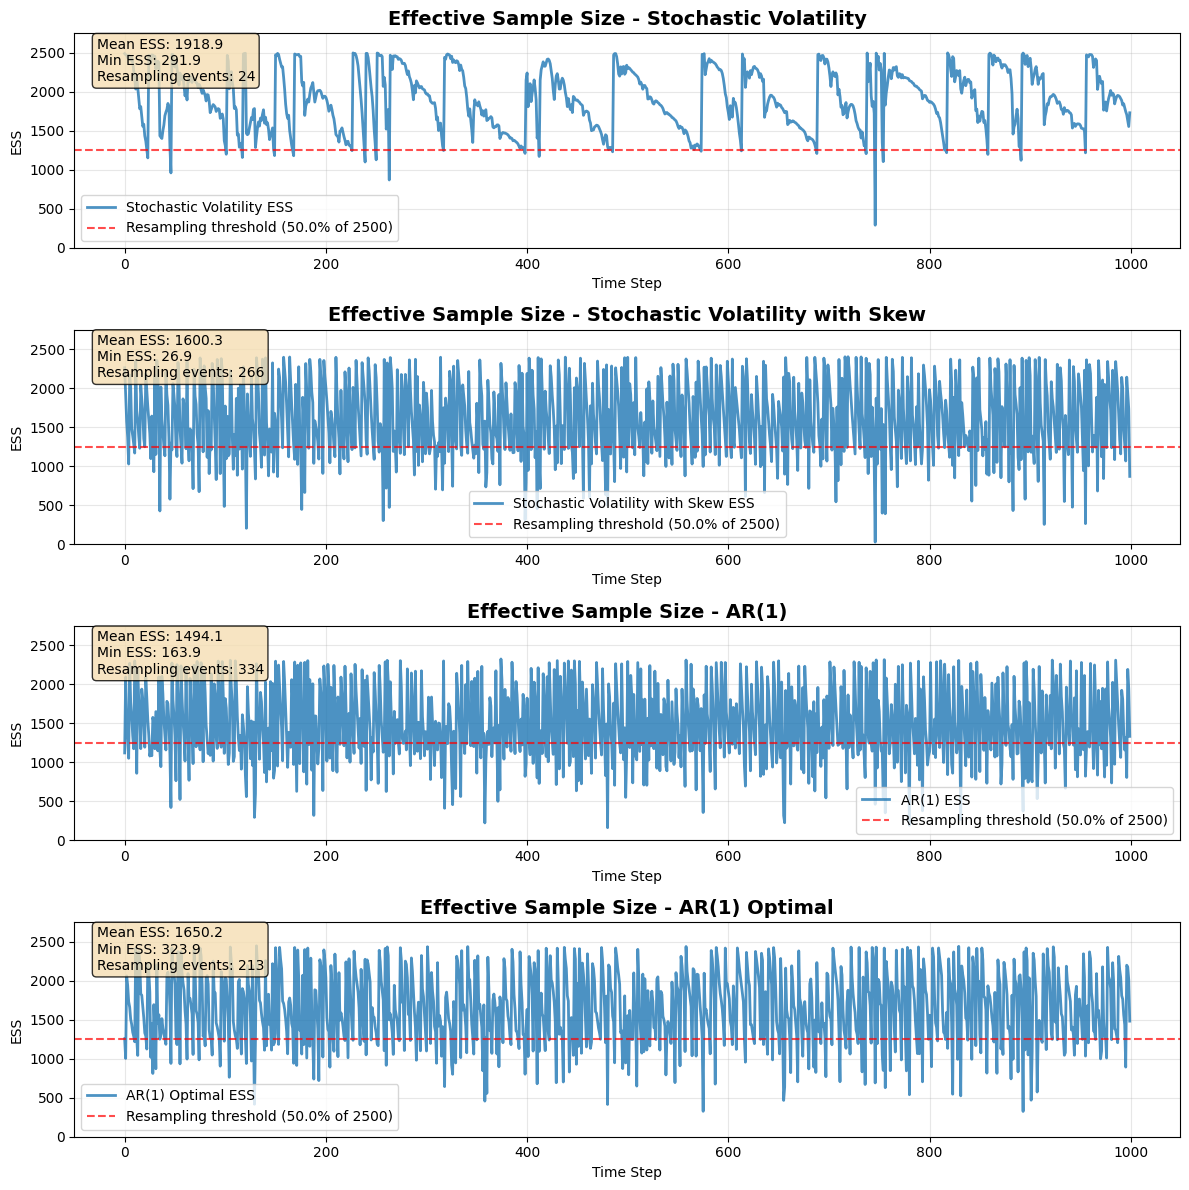

In [14]:
# --- Test Particle Filter for Each Example Using Simulated Data ---
import jax
from nnp_functions.particle_filter import ParticleFilter

# Settings
N_PARTICLES = 2500  # Number of particles for the filter
N_RUNS = 3        # Number of simulated runs (trajectories)
N_STEPS = 1000      # Number of time steps
SEED = 42

examples = [
    {
        'name': 'Stochastic Volatility',
        'vehicle': stoch_pf_vehicle,
        'sample_fn': sample_fn_from_f_from_noise(f_from_noise),
        'weight_fn': g_likelihood_single,
    },
    {
        'name': 'Stochastic Volatility with Skew',
        'vehicle': skew_pf_vehicle,
        'sample_fn': sample_fn_from_f_from_noise(f_from_noise),
        'weight_fn': skew_observation_weight_single,
    },
    {
        'name': 'AR(1)',
        'vehicle': ar1_pf_vehicle,
        'sample_fn': sample_fn_from_f_from_noise(f_from_noise),
        'weight_fn': ar1_g_likelihood_single,
    },
    {
        'name': 'AR(1) Optimal',
        'vehicle': ar1_pf_vehicle,
        'sample_fn': ar1_optimal_sample,
        'weight_fn': ar1_optimal_likelihood_single,
    },
]

# Create a figure with subplots for ESS plots
fig, axes = plt.subplots(len(examples), 1, figsize=(12, 3*len(examples)))
if len(examples) == 1:
    axes = [axes]

for i, ex in enumerate(examples):
    print(f"\n--- Testing Particle Filter: {ex['name']} ---")
    key = jax.random.PRNGKey(SEED)
    # Generate simulated data
    X_paths, Y_paths = ex['vehicle'].generate_data(key, N_RUNS, N_STEPS, X_BAR)
    X_true = X_paths[0]  # shape: (N_STEPS,)
    Y_obs = Y_paths[0]   # shape: (N_STEPS,)

    
    # Set up initial particles and weights
    initial_particles = jax.random.normal(key, (N_PARTICLES,)) * 0.1 + X_BAR
    initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)

    # Instantiate ParticleFilter
    pf = ParticleFilter(
        sample_fn=ex['sample_fn'],
        weight_fn=ex['weight_fn'],
        N_PARTICLES=N_PARTICLES
    )

    # Run the filter
    out_particles, out_log_weights, diagnostics = pf.simulate(
        key, initial_particles, initial_log_weights, Y_obs, X_true
    )

    # Plot ESS with improved styling
    ess_values = diagnostics['ess']
    time_steps = jnp.arange(len(ess_values))
    
    axes[i].plot(time_steps, ess_values, linewidth=2, alpha=0.8, label=f'{ex["name"]} ESS')
    axes[i].axhline(y=N_PARTICLES * pf.ESS_COND, color='red', linestyle='--', alpha=0.7, 
                   label=f'Resampling threshold ({pf.ESS_COND:.1%} of {N_PARTICLES})')
    axes[i].set_title(f'Effective Sample Size - {ex["name"]}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('ESS')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, N_PARTICLES * 1.1)
    
    # Add text box with summary statistics
    average_ess = jnp.mean(ess_values)
    min_ess = jnp.min(ess_values)
    resampling_events = jnp.sum(diagnostics['resample_flag'])
    textstr = f'Mean ESS: {average_ess:.1f}\nMin ESS: {min_ess:.1f}\nResampling events: {resampling_events}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=10,
                verticalalignment='top', bbox=props)

    # Print diagnostics
    mean_est = jnp.mean(diagnostics['mean_squared_error'])
    print(f"Final ESS: {average_ess:.2f}")
    print(f"Average MSE: {mean_est:.5e}")

plt.tight_layout()
plt.show()


Testing Particle Filter: Stochastic Volatility
The X array starts at -1.8304332
(2500,)


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

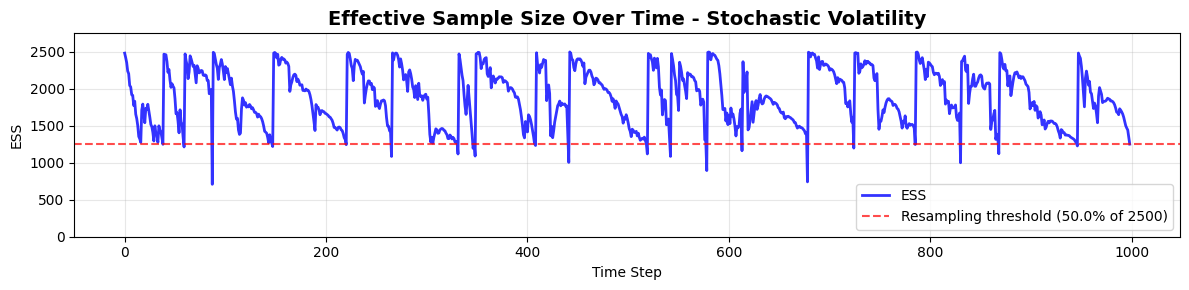


Diagnostics for Stochastic Volatility:
Final ESS: 1252.30
Average ESS: 1893.42
Min ESS: 708.67
Total resampling events: 21.0
Average marginal likelihood: 492.3988
Forward simulation likelihoods: {749: {'likelihood': Array([0.72000074], dtype=float32), 'kde_mse': Array(0.00823436, dtype=float32), 'total_mse': Array(0.1277162, dtype=float32), 'total_coverage': Array(0.192, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-0.9556, Estimated=-1.0005, Diff=0.0449
  At time -1: True=-0.7977, Estimated=-0.8315, Diff=0.0337

------------------------------------------------------------


Testing Particle Filter: Stochastic Volatility with Skew
The X array starts at -1.8304332
(2500,)


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

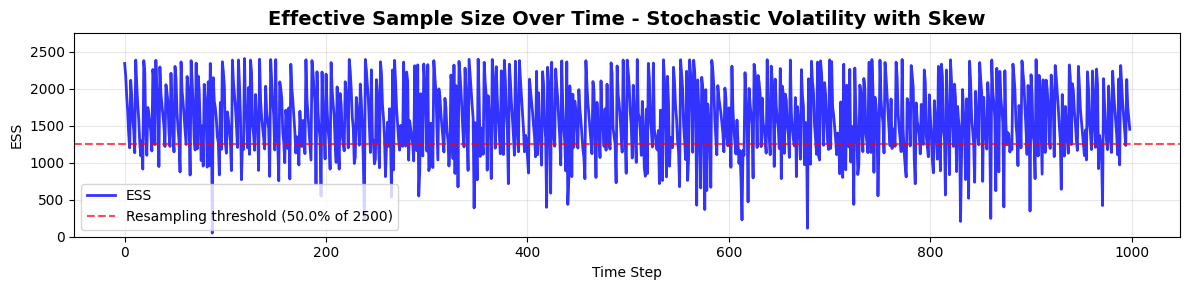


Diagnostics for Stochastic Volatility with Skew:
Final ESS: 1452.38
Average ESS: 1586.01
Min ESS: 49.29
Total resampling events: 268.0
Average marginal likelihood: 563.8571
Forward simulation likelihoods: {749: {'likelihood': Array([-2.8421125], dtype=float32), 'kde_mse': Array(289.62338, dtype=float32), 'total_mse': Array(0.24550161, dtype=float32), 'total_coverage': Array(0., dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-0.9556, Estimated=-1.1757, Diff=0.2202
  At time -1: True=-0.7977, Estimated=-0.9151, Diff=0.1174

------------------------------------------------------------


Testing Particle Filter: AR(1)
The X array starts at -1.8304332
(2500,)


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

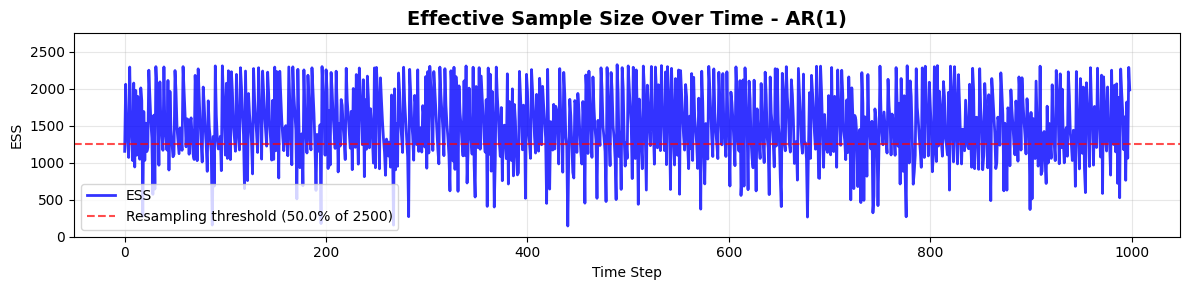


Diagnostics for AR(1):
Final ESS: 1986.27
Average ESS: 1504.35
Min ESS: 144.88
Total resampling events: 330.0
Average marginal likelihood: 6.1355
Forward simulation likelihoods: {749: {'likelihood': Array([-12.038991], dtype=float32), 'kde_mse': Array(3.649817e+09, dtype=float32), 'total_mse': Array(0.0891867, dtype=float32), 'total_coverage': Array(0.29200003, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-0.9556, Estimated=-0.9421, Diff=0.0135
  At time -1: True=-0.7977, Estimated=-0.8000, Diff=0.0022

------------------------------------------------------------


Testing Particle Filter: AR(1) Optimal
The X array starts at -1.8304332
(2500,)


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

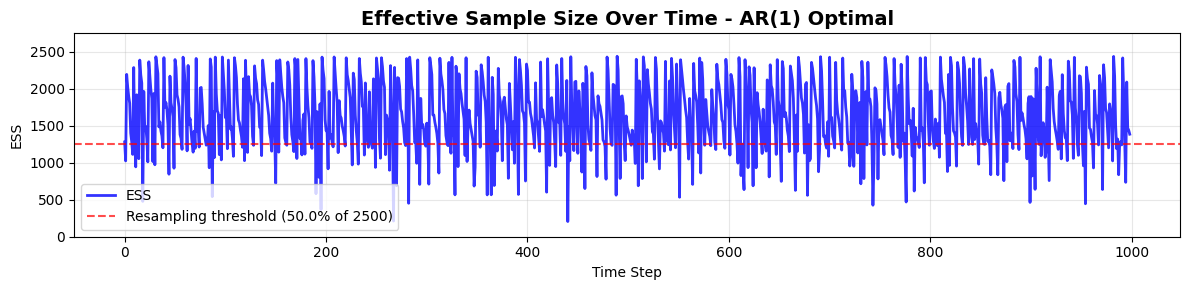


Diagnostics for AR(1) Optimal:
Final ESS: 1386.14
Average ESS: 1634.14
Min ESS: 205.47
Total resampling events: 214.0
Average marginal likelihood: 6.1331
Forward simulation likelihoods: {749: {'likelihood': Array([-12.036119], dtype=float32), 'kde_mse': Array(3.6748713e+09, dtype=float32), 'total_mse': Array(0.08958268, dtype=float32), 'total_coverage': Array(0.29200003, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-0.9556, Estimated=-0.9422, Diff=0.0134
  At time -1: True=-0.7977, Estimated=-0.8003, Diff=0.0026

------------------------------------------------------------



In [21]:
# --- Test Particle Filter for Each Example Using Simulated Data ---
import jax
import matplotlib.pyplot as plt
import numpy as np
from nnp_functions.particle_filter import ParticleFilter

# Settings
N_PARTICLES = 2500  # Number of particles for the filter
N_RUNS = 1         # Number of simulated runs (trajectories)
N_STEPS = 1000      # Number of time steps
SEED = 42

for ex in examples:
    print(f"\n{'='*60}")
    print(f"Testing Particle Filter: {ex['name']}")
    print(f"{'='*60}")
    
    key = jax.random.PRNGKey(4)
    
    # Generate simulated data
    X_paths, Y_paths = ex['vehicle'].generate_data(key, N_RUNS, N_STEPS, X_BAR)
    X_true = X_paths[0]  # shape: (N_STEPS,)
    Y_obs = Y_paths[0]   # shape: (N_STEPS,)

    print('The X array starts at', X_true[0])


    # Set up initial particles and weights
    initial_particles = jax.random.normal(key, (N_PARTICLES,)) * 0.1 + X_BAR

    # Instantiate ParticleFilter
    pf = ParticleFilter(
        sample_fn=ex['sample_fn'],
        weight_fn=ex['weight_fn'],
        N_PARTICLES=N_PARTICLES
    )

    print(initial_particles.shape)

    # Run the filter, through the vehicle.
    merged_diagnostics, particle_and_weights_at_flag_idx, likelihood_list = ex['vehicle'].run_from_particle_filter(
        key, 
        pf, 
        Y_obs,
        X_true,
        initial_particles,
        [0.75],
        TAU
    )


    # Create figure for ESS plot
    plt.figure(figsize=(12, 3))
    
    # Plot ESS over time
    ess_values = merged_diagnostics['ess']
    
    time_steps = jnp.arange(len(ess_values))
    
    plt.plot(time_steps, ess_values, linewidth=2, color='blue', alpha=0.8, label='ESS')
    plt.axhline(y=N_PARTICLES * pf.ESS_COND, color='red', linestyle='--', alpha=0.7, 
               label=f'Resampling threshold ({pf.ESS_COND:.1%} of {N_PARTICLES})')
    plt.title(f'Effective Sample Size Over Time - {ex["name"]}', fontsize=14, fontweight='bold')
    plt.xlabel('Time Step')
    plt.ylabel('ESS')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, N_PARTICLES * 1.1)
    
    plt.tight_layout()
    plt.show()

    # Print diagnostics
    print(f"\nDiagnostics for {ex['name']}:")
    print(f"Final ESS: {ess_values[-1]:.2f}")
    print(f"Average ESS: {jnp.mean(ess_values):.2f}")
    print(f"Min ESS: {jnp.min(ess_values):.2f}")
    print(f"Total resampling events: {jnp.sum(merged_diagnostics['resample_flag'])}")
    print(f"Average marginal likelihood: {jnp.mean(merged_diagnostics['marginal_likelihood']):.4f}")
    if likelihood_list:
        print(f"Forward simulation likelihoods: {likelihood_list}")
    
    # Print estimated vs true values at forecast points
    forecast_indices = list(particle_and_weights_at_flag_idx.keys())
    print(f"\nForecast Point Comparisons:")
    for i, forecast_idx in enumerate(forecast_indices):
        particles, weights = particle_and_weights_at_flag_idx[forecast_idx]
        weights_normalized = jnp.exp(weights) / jnp.sum(jnp.exp(weights))
        estimated_value = jnp.sum(particles * weights_normalized)
        true_value = X_true[forecast_idx]
        print(f"  At time {forecast_idx}: True={true_value:.4f}, Estimated={estimated_value:.4f}, Diff={abs(true_value-estimated_value):.4f}")

    print(f"\n{'-'*60}\n")


## Investigating the forecasting distributions. 

## Testing model training. 

Import the model from the NeuralNetworks class. Then try to train the model using the newly written function.


--- Training NN model for: Stochastic Volatility ---


  0%|          | 0/1000 [00:00<?, ?it/s]

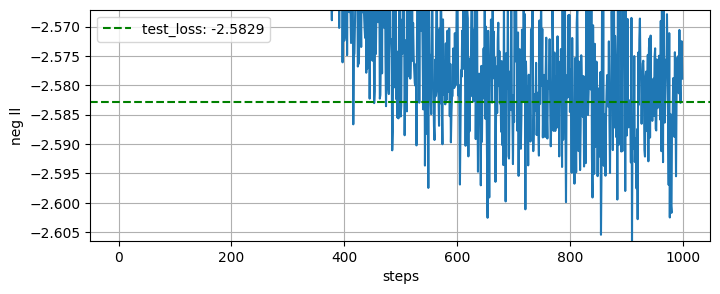


--- Training NN model for: Stochastic Volatility with Skew ---


  0%|          | 0/1000 [00:00<?, ?it/s]

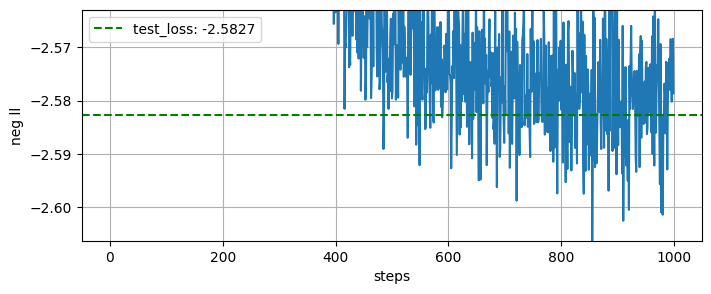


--- Training NN model for: AR(1) ---


  0%|          | 0/1000 [00:00<?, ?it/s]

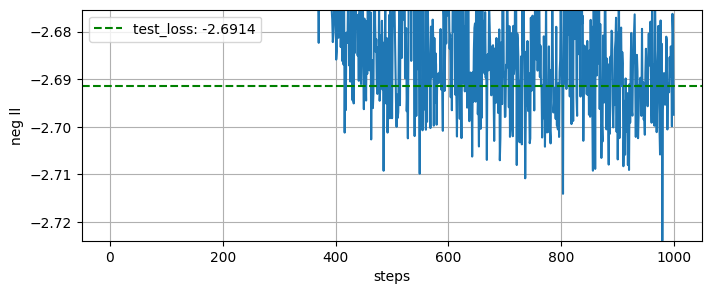


--- Training NN model for: AR(1) Optimal ---


  0%|          | 0/1000 [00:00<?, ?it/s]

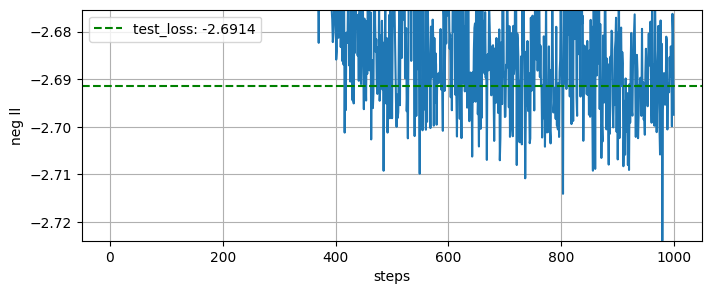

In [16]:
from nnp_functions.neural_networks import FeedForwardNetwork

# Train a model for each example's vehicle and build a NN-based particle filter for each
trained_nn_pfs = []
for ex in examples:
    print(f"\n--- Training NN model for: {ex['name']} ---")
    # Create a new model for each example
    initial_model = FeedForwardNetwork(n_layers=1, hidden_dim=64, key=jax.random.PRNGKey(0))
    # Train the model using the vehicle's train_model method
    ex['vehicle'].train_model(jax.random.PRNGKey(0), initial_model, 5000, X_bar=X_BAR)
    # Build the NN-based particle filter and store it
    nn_pf = ex['vehicle'].build_NN_particle_filter(N_PARTICLES=N_PARTICLES)
    trained_nn_pfs.append(nn_pf)

# --- Test Particle Filter for Each Example Using Simulated Data ---
import jax
from nnp_functions.particle_filter import ParticleFilter

# Settings
N_PARTICLES = 2500  # Number of particles for the filter
N_RUNS = 3        # Number of simulated runs (trajectories)
N_STEPS = 1000      # Number of time steps
SEED = 42


--- Testing Particle Filter: Stochastic Volatility ---


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

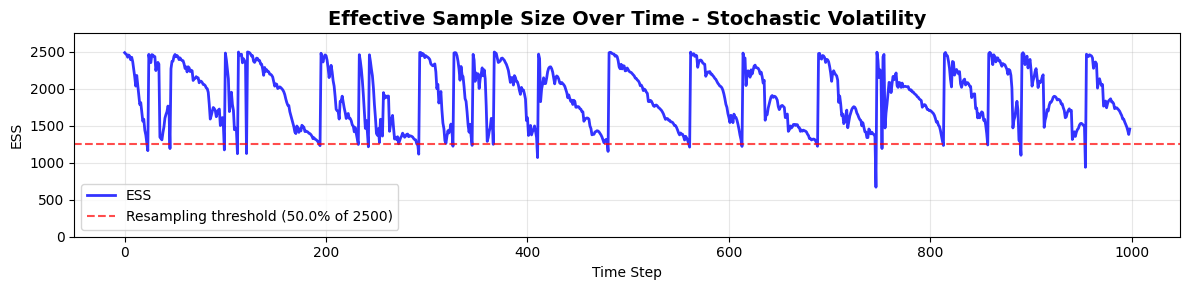


Diagnostics for Stochastic Volatility:
Final ESS: 1456.00
Average ESS: 1892.81
Min ESS: 669.81
Total resampling events: 23.0
Average marginal likelihood: 468.3087
Forward simulation likelihoods: {749: {'likelihood': Array([1.6903844], dtype=float32), 'kde_mse': Array(0.00115339, dtype=float32), 'total_mse': Array(0.10214129, dtype=float32), 'total_coverage': Array(0.384, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-1.4976, Estimated=-1.5383, Diff=0.0407
  At time -1: True=-1.2607, Estimated=-1.1972, Diff=0.0635

------------------------------------------------------------


--- Testing Particle Filter: Stochastic Volatility with Skew ---


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

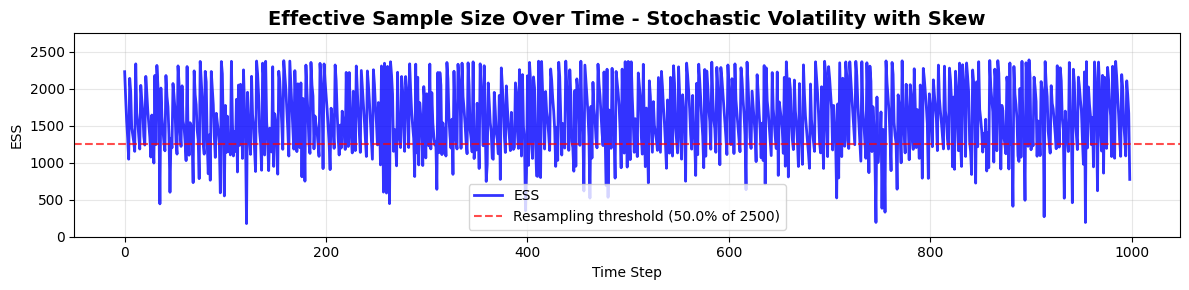


Diagnostics for Stochastic Volatility with Skew:
Final ESS: 775.10
Average ESS: 1602.63
Min ESS: 177.64
Total resampling events: 269.0
Average marginal likelihood: 534.5325
Forward simulation likelihoods: {749: {'likelihood': Array([-1.7250466], dtype=float32), 'kde_mse': Array(33.45325, dtype=float32), 'total_mse': Array(0.1945632, dtype=float32), 'total_coverage': Array(0.02, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-1.4976, Estimated=-1.7134, Diff=0.2159
  At time -1: True=-1.2607, Estimated=-1.3053, Diff=0.0446

------------------------------------------------------------


--- Testing Particle Filter: AR(1) ---


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

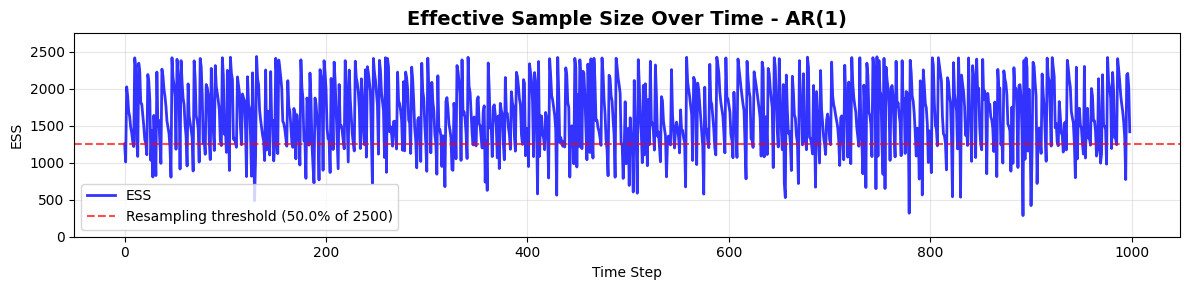


Diagnostics for AR(1):
Final ESS: 1418.76
Average ESS: 1636.75
Min ESS: 285.86
Total resampling events: 219.0
Average marginal likelihood: 5.9854
Forward simulation likelihoods: {749: {'likelihood': Array([-12.531426], dtype=float32), 'kde_mse': Array(9.591288e+09, dtype=float32), 'total_mse': Array(0.09843679, dtype=float32), 'total_coverage': Array(0.224, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-1.4976, Estimated=-1.5535, Diff=0.0559
  At time -1: True=-1.2607, Estimated=-1.2991, Diff=0.0384

------------------------------------------------------------


--- Testing Particle Filter: AR(1) Optimal ---


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

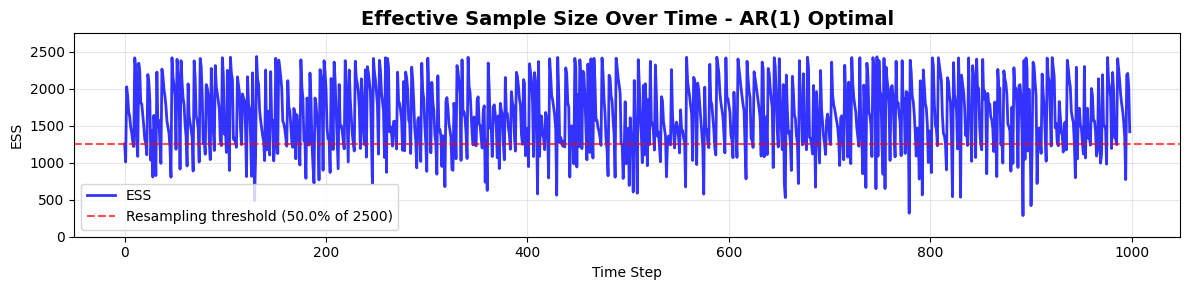


Diagnostics for AR(1) Optimal:
Final ESS: 1418.76
Average ESS: 1636.75
Min ESS: 285.86
Total resampling events: 219.0
Average marginal likelihood: 5.9854
Forward simulation likelihoods: {749: {'likelihood': Array([-12.531426], dtype=float32), 'kde_mse': Array(9.591288e+09, dtype=float32), 'total_mse': Array(0.09843679, dtype=float32), 'total_coverage': Array(0.224, dtype=float32)}}

Forecast Point Comparisons:
  At time 749: True=-1.4976, Estimated=-1.5535, Diff=0.0559
  At time -1: True=-1.2607, Estimated=-1.2991, Diff=0.0384

------------------------------------------------------------



In [17]:
# Create a figure with subplots for ESS plots

for i, ex in enumerate(examples):
    print(f"\n--- Testing Particle Filter: {ex['name']} ---")
    key = jax.random.PRNGKey(SEED)
    # Generate simulated data
    X_paths, Y_paths = ex['vehicle'].generate_data(key, N_RUNS, N_STEPS, X_BAR)
    X_true = X_paths[0]  # shape: (N_STEPS,)
    Y_obs = Y_paths[0]   # shape: (N_STEPS,)

    # Set up initial particles and weights
    initial_particles = jax.random.normal(key, (N_PARTICLES,)) * 0.1 + X_BAR
    initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)

    # Use the trained NN-based particle filter for this example
    pf = trained_nn_pfs[i]

    # Run the filter, through the vehicle.
    merged_diagnostics, particle_and_weights_at_flag_idx, likelihood_list = ex['vehicle'].run_from_particle_filter(
        key, 
        pf, 
        Y_obs,
        X_true,
        initial_particles,
        [0.75],
        TAU
    )


    # Create figure for ESS plot
    plt.figure(figsize=(12, 3))
    
    # Plot ESS over time
    ess_values = merged_diagnostics['ess']
    
    time_steps = jnp.arange(len(ess_values))
    
    plt.plot(time_steps, ess_values, linewidth=2, color='blue', alpha=0.8, label='ESS')
    plt.axhline(y=N_PARTICLES * pf.ESS_COND, color='red', linestyle='--', alpha=0.7, 
               label=f'Resampling threshold ({pf.ESS_COND:.1%} of {N_PARTICLES})')
    plt.title(f'Effective Sample Size Over Time - {ex["name"]}', fontsize=14, fontweight='bold')
    plt.xlabel('Time Step')
    plt.ylabel('ESS')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, N_PARTICLES * 1.1)
    
    plt.tight_layout()
    plt.show()

    # Print diagnostics
    print(f"\nDiagnostics for {ex['name']}:")
    print(f"Final ESS: {ess_values[-1]:.2f}")
    print(f"Average ESS: {jnp.mean(ess_values):.2f}")
    print(f"Min ESS: {jnp.min(ess_values):.2f}")
    print(f"Total resampling events: {jnp.sum(merged_diagnostics['resample_flag'])}")
    print(f"Average marginal likelihood: {jnp.mean(merged_diagnostics['marginal_likelihood']):.4f}")
    if likelihood_list:
        print(f"Forward simulation likelihoods: {likelihood_list}")
    
    # Print estimated vs true values at forecast points
    forecast_indices = list(particle_and_weights_at_flag_idx.keys())
    print(f"\nForecast Point Comparisons:")
    for i, forecast_idx in enumerate(forecast_indices):
        particles, weights = particle_and_weights_at_flag_idx[forecast_idx]
        weights_normalized = jnp.exp(weights) / jnp.sum(jnp.exp(weights))
        estimated_value = jnp.sum(particles * weights_normalized)
        true_value = X_true[forecast_idx]
        print(f"  At time {forecast_idx}: True={true_value:.4f}, Estimated={estimated_value:.4f}, Diff={abs(true_value-estimated_value):.4f}")

    print(f"\n{'-'*60}\n")


In [18]:
a = jnp.array([[1, 2, 3],
               [4, 5, 6]])

lower_quantiles = jnp.quantile(a, 0.2, axis=0)
upper_quantiles = jnp.quantile(a, 0.8, axis=0)

test_val = jnp.array([1, 2, 3])

print(jnp.mean((test_val > lower_quantiles) & (test_val < upper_quantiles)))

0.0
